# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric
from sklearn.metrics import pairwise_kernels
from sklearn_extra.cluster import KMedoids
import matplotlib as mpl
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML

- This script applies PCA to reduce the dimensions of the California Housing dataset, and performs K-Medoids clustering with the 'k-medoids++' initialization method. The script:
  1. Clusters the data using K-Medoids and visualizes the geographical distribution of clusters on a map, where each cluster is color-coded and displayed with respect to longitude and latitude.
  2. Includes an animated visualization demonstrating the iterative process of medoid movement to their optimal positions. The animation provides a dynamic view of how medoids shift within the dataset to better represent their respective clusters.
  3. Configures plotting styles and parameters to enhance the visualization aesthetics and readability, making it clear and engaging for presentation or analytical purposes.

# Data Loading & Preprocessing

In [2]:
path = 'C:\\Users\\zcindemir\\Desktop\\Data Mining Project\\housing.csv'
housing = pd.read_csv(path)

housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)

encoder = OneHotEncoder()
ocean_proximity_encoded = encoder.fit_transform(housing[['ocean_proximity']]).toarray()
feature_names = encoder.get_feature_names_out(['ocean_proximity'])
ocean_proximity_df = pd.DataFrame(ocean_proximity_encoded, columns=feature_names)
housing_encoded = pd.concat([housing.drop('ocean_proximity', axis=1), ocean_proximity_df], axis=1)

scaler = StandardScaler()
housing_scaled = scaler.fit_transform(housing_encoded)

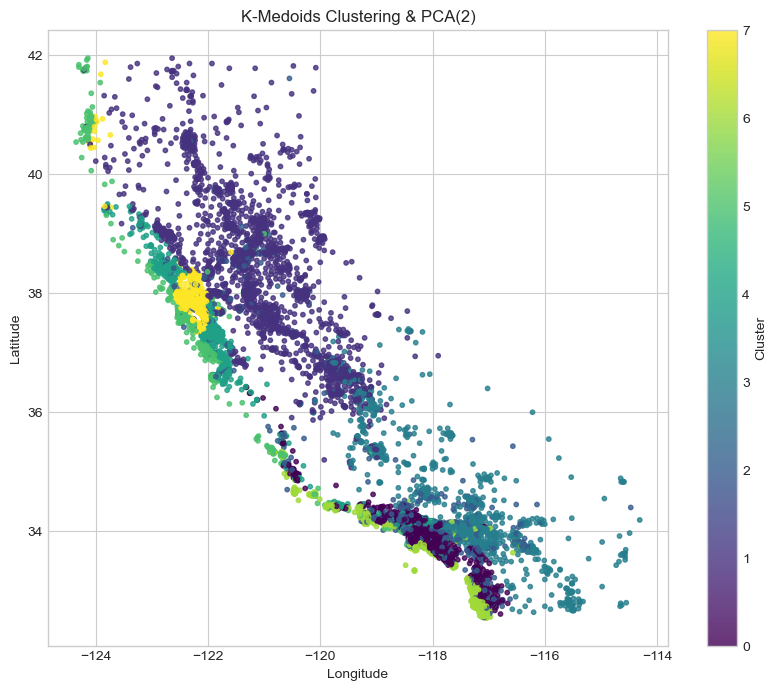

In [3]:
pca = PCA(n_components=4)
housing_pca = pca.fit_transform(housing_scaled)

kmedoids = KMedoids(init='k-medoids++', random_state=42)
labels = kmedoids.fit_predict(housing_pca)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))
scatter = plt.scatter(housing['longitude'], housing['latitude'], c=labels, cmap='viridis', s=10, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.title('K-Medoids Clustering & PCA(4)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [4]:
mpl.rc('animation', html='html5')
plt.style.use(style="seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def initialize_centroids(points, k):
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

def closest_centroid(points, centroids):
    distances = np.sqrt(((points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0)

def move_medoids(points, closest, centroids):
    new_centroids = np.zeros_like(centroids)
    for k in range(centroids.shape[0]):
        cluster_points = points[closest == k]
        medoid_index = np.argmin(np.sum(np.sqrt(((cluster_points - cluster_points[:, np.newaxis])**2).sum(axis=2)), axis=1))
        new_centroids[k] = cluster_points[medoid_index]
    return new_centroids

k = 6
centroids = initialize_centroids(housing_scaled, k)

colors = sns.color_palette(n_colors=k)
fig, ax = plt.subplots(figsize=(10, 8))

longitude_index = housing_encoded.columns.get_loc("longitude")
latitude_index = housing_encoded.columns.get_loc("latitude")


def animate(i):
    global centroids
    closest = closest_centroid(housing_scaled, centroids)
    centroids = move_medoids(housing_scaled, closest, centroids)
    
    ax.clear()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    ax.scatter(housing_encoded['longitude'], housing_encoded['latitude'], c='gray', alpha=0.1)
    for idx in range(k):
        cluster_points = housing_scaled[closest == idx]
        points = scaler.inverse_transform(cluster_points)
        ax.scatter(points[:, longitude_index], points[:, latitude_index], c=[colors[idx]], alpha=0.6)

    centroid_points = scaler.inverse_transform(centroids)
    ax.scatter(centroid_points[:, longitude_index], centroid_points[:, latitude_index], c='red', s=100, edgecolors='k', marker='X')
    ax.set_xlim([housing['longitude'].min(), housing['longitude'].max()])
    ax.set_ylim([housing['latitude'].min(), housing['latitude'].max()])

ani = animation.FuncAnimation(fig, animate, frames=25, interval=300)


plt.close()
HTML(ani.to_jshtml())